In [271]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils import parameters_to_vector
from torch.optim import Adam
from torch.distributions import MultivariateNormal, Normal
from preds.models import MLPS

from preds.likelihoods import CategoricalLh
from preds.datasets import UCIClassificationDatasets
from preds.laplace import Laplace

Includes some playing around with the Immer et al. dataset and model classes and a script for running the UCI experiemnts (with hyperparameters as in the paper appendix)

Testing the dataset and model classes

In [ ]:
width = 50 # as in Immer et al. 
depth = 2 # as in Immer et al. 
prior_prec = np.logspace(-2, 2, num=10)[0] # as in Immer et al. but depends on dataset
lr = 1e-3 # as in Immer et al. 
n_epochs = 10000
n_samples = 1000
train_size = 0.70 # as in Immer et al. 
lh = CateoricalLh()  
uci_dataset = 'glass'
root_dir = '../data/'
device = 'cpu'

Load training data

In [ ]:
ds_train = UCIClassificationDatasets(train=True, data_set=uci_dataset, split_train_size=train_size, double=False, root=root_dir)
X_train, y_train = ds_train.data.to(device), ds_train.targets.to(device).unsqueeze(1)
train_loader = [(X_train, y_train)]  

Load validation data

In [ ]:
ds_val = UCIClassificationDatasets(train=False,valid=True, data_set=uci_dataset, split_train_size=train_size, double=False, root=root_dir)
X_val, y_val = ds_val.data.to(device), ds_val.targets.to(device).unsqueeze(1)
val_loader = [(X_val, y_val)] 

In [ ]:
X_train.shape

In [ ]:
model = MLPS(X_train.shape[1], [width]*depth, 1, activation='tanh', flatten=False).to(device)
optim = Adam(model.parameters(), lr=lr)
losses = list()
for i in range(n_epochs):
    f = model(X_train)
    w = parameters_to_vector(model.parameters())
    reg = 0.5 * prior_prec * w @ w
    loss = - lh.log_likelihood(y_train, f) + reg
    loss.backward()
    optim.step()
    losses.append(loss.item())
    model.zero_grad()


In [ ]:
lap = Laplace(model, float(prior_prec), lh)


def get_pred_for(x, model_type='glm', cov_type='full'):
    #### INFERENCE (Posterior approximation) ####
    lap.infer(train_loader, cov_type=cov_type, dampen_kron=model_type=='bnn')
    if model_type == 'glm':
        #### GLM PREDICTIVE ####
        mu, var = lap.predictive_samples_glm(x, n_samples=n_samples)
    elif model_type == 'bnn':
        #### BNN PREDICTIVE ####
        samples = lap.predictive_samples_bnn(x, n_samples=n_samples)
        mu = samples.mean(axis=0)
        var = samples.cov(axis=0)
    else:
        raise ValueError('unsupported model_type.')
    mu = mu.detach().cpu().squeeze()
    var = var.detach().cpu().squeeze()
    return mu, var

In [ ]:
print(X_train.dtype)
print(X_val.dtype)
print(mu.dtype)

In [ ]:
# GLM

mu_glm, var_glm = get_pred_for(X_val, 'glm', 'full')# runs
# mu_glm_kron, var_glm_kron = get_pred_for(X_val, 'glm', 'kron') # doesn't run
#mu, var = get_pred_for(X_val, 'glm', 'diag')# doesn't run

# BNN
mu_bnn, var_bnn = get_pred_for(X_val, 'bnn', 'full')

In [ ]:
y_val.shape

In [ ]:
lh_glm = Normal(mu_glm, var_glm)
print(-torch.mean(lh_glm.log_prob(y_val.squeeze(-1))))

In [ ]:
lh_bnn = Normal(mu_bnn, var_bnn)
print(-torch.mean(lh_bnn.log_prob(y_val.squeeze(-1))))

<h2>Run the classification pipeline for chosen dataset </h2>

The classification.py script tests 10 options for the prior precision, with a fixed train/val/test split. The results reported in the paper are over 10 different train/val/test splits

In [8]:
datasets = ['australian', 'breast_cancer', 'digits', 'glass',
            'ionosphere', 'satellite', 'vehicle', 'waveform']
seeds = [711, 1, 75, 359, 17, 420, 129, 666, 69, 36]
dataset = 'breast_cancer'

In [ ]:
for seed in seeds:
    if dataset in ['satellite', 'digits']:
        logmin = -1.0
    else:
        logmin = -2.0
    !python3 ../experiments/classification.py -d {dataset} --root_dir ../ --seed {seed} --n_layers 2 --activation tanh --name tanh_2 --logd_min {logmin}

Writing results to ../experiments/results
Reading data from ../data
100%|██████████████████████████████████████████| 10/10 [42:12<00:00, 253.22s/it]
Writing results to ../experiments/results
Reading data from ../data
100%|██████████████████████████████████████████| 10/10 [53:43<00:00, 322.32s/it]
Writing results to ../experiments/results
Reading data from ../data
100%|██████████████████████████████████████████| 10/10 [44:43<00:00, 268.37s/it]
Writing results to ../experiments/results
Reading data from ../data
 60%|█████████████████████████▊                 | 6/10 [24:45<16:41, 250.35s/it]

The experiment in experiments/uci_classification_commands.py could otherwise be used, but it does not take into account the different hyperparameter settings required for satellite & digits datasets (different range for prior precision)

<h2> Manual reading of the result pickle</h2>
Read the result pickle (for a single experiment with various prior precisions)

Find  which prior precision gives the best validation NLL for the dataset (based on average NLL performance)

In [276]:
def get_val_best(result_list, model_name='svgp_ntk'):
    valid_nlls = np.zeros((len(result_list), len(result_list[0]['deltas'])))
    for i, results in enumerate(result_list):
        for j, res in enumerate(results['results']):
            if f'valid_nll_{model_name}' not in res:
                continue
            valid_nlls[i, j] = res[f'valid_nll_{model_name}']
    mean_nlls = np.mean(valid_nlls, axis=0)
    min_nll = mean_nlls.min()
    min_index = list(mean_nlls).index(min_nll)
    return min_index

def get_result_list(dataset,folder_name,  name, seeds):   
    result_list = []
    for seed in seeds:
        file_name = f'../experiments/results/uci/{folder_name}/classification_{dataset}_{name}_{seed}.pkl'
        if os.path.isfile(file_name):
            with open(file_name, 'rb') as handle:
                result_list.append(pickle.load(handle))
        else:
            print(f'WARNING: No results for seed {seed}, dataset {dataset}')
    return result_list

Check the test set performance of the selected prior precision

In [242]:
def get_test_mean_std(result_list, min_idx, name='svgp_ntk'):
    test_nlls = np.zeros(len(result_list))
    for i, results in enumerate(result_list):
        test_nlls[i] = results['results'][min_idx][f'test_nll_{name}']
    mean = np.mean(test_nlls)
    std = np.std(test_nlls)
    return (mean, std)

<h2>Automatic table creation </h2>

In [325]:
method_map = {
    'NN MAP':  [(0.31, 0.01), (0.11, 0.02), (0.35, 0.02), (0.95,0.03), (0.420, 0.007), (0.335, 0.004), (0.094, 0.003), (0.230, 0.002)],
'MFVI': [(0.34, 0.01), (0.11, 0.01), (0.41, 0.01), (1.06,0.01), (0.504, 0.006), (0.393, 0.003), (0.219, 0.004), (0.307, 0.002)],
'BNN' : [(0.42, 0.00), (0.19, 0.00), (0.50, 0.00), (1.41,0.00), (0.885, 0.002), (0.516, 0.002), (0.875, 0.002), (0.482, 0.001)],
'GLM' : [(0.32, 0.02), (0.10, 0.01), (0.29, 0.01), (0.86,0.01), (0.428, 0.005), (0.339, 0.004), (0.250, 0.002), (0.241, 0.001)],
'GLM diag' : [(0.33, 0.01), (0.11, 0.01), (0.35, 0.01), (0.99,0.01), (0.618, 0.003), (0.388, 0.003), (0.409, 0.002), (0.327, 0.002)],
'GLM refine' :[(0.32, 0.02), (0.11, 0.01), (0.35, 0.05), (0.98,0.07), (0.402, 0.007), (0.335, 0.004), (0.150, 0.002), (0.227, 0.002)],
'GLM refine d' : [(0.31, 0.01), (0.12, 0.02), (0.32, 0.03), (0.83,0.02), (0.432, 0.005), (0.364, 0.008), (0.149, 0.008), (0.248, 0.002)],
}


In [161]:
'valid_nll_svgp_ntk' in result_list[5]['results'][4].keys()

True

In [326]:

inducing_points = [16, 32, 64, 128, 256, 'all']# [16, 32, 64, 128]
folder_name = '09'
pretty_names = {'sparse_16_svgp_ntk': 'SVGP (16)',
                'sparse_32_svgp_ntk': 'SVGP (32)',
                'sparse_64_svgp_ntk': 'SVGP (64)',
                'sparse_128_svgp_ntk': 'SVGP (128)',
                'sparse_256_svgp_ntk': 'SVGP (256)',
                'sparse_all_svgp_ntk': 'GP all',
               'sparse_16_gp_subset': 'GP subset(16)',
               'sparse_32_gp_subset': 'GP subset(32)',
               'sparse_64_gp_subset': 'GP subset(64)',
               'sparse_128_gp_subset': 'GP subset(128)',          
               'sparse_256_gp_subset': 'GP subset(256)',
                'sparse_all_gp_subset': 'GP all (subset)',}
method_names = ['svgp_ntk', 'gp_subset']
datasets = ['australian', 'breast_cancer', 'ionosphere','glass',
            'vehicle','waveform', 'digits', 'satellite']
data_names = ['australian', 'cancer', 'ionosphere', 'glass', 'vehicle', 'waveform', 'digits', 'satellite']
seeds = [711, 1, 75, 359, 17, 420, 129, 666, 69, 36]
for n_inducing in inducing_points:
    print(f'Gathering results for {n_inducing}')
    exp_name = f'sparse_{n_inducing}'
    for method_name in method_names:
        table_list = []
        for dataset in datasets:
            result_list = get_result_list(dataset, folder_name, exp_name, seeds)
            if len(result_list) < 10:
                print(f'WARNING: N seeds for {dataset}:')
                print(len(result_list))
                table_list.append((0, 0))
                continue
            min_idx = get_val_best(result_list, method_name)
            (mean, std) = get_test_mean_std(result_list, min_idx, name=method_name)
            table_list.append((round(mean, 3), round(std, 3)))
        method_map[pretty_names[f'sparse_{n_inducing}_{method_name}']] = table_list
        

Gathering results for 16
Gathering results for 32
Gathering results for 64
Gathering results for 128
Gathering results for 256
Gathering results for all


In [327]:
method_map

{'NN MAP': [(0.31, 0.01),
  (0.11, 0.02),
  (0.35, 0.02),
  (0.95, 0.03),
  (0.42, 0.007),
  (0.335, 0.004),
  (0.094, 0.003),
  (0.23, 0.002)],
 'MFVI': [(0.34, 0.01),
  (0.11, 0.01),
  (0.41, 0.01),
  (1.06, 0.01),
  (0.504, 0.006),
  (0.393, 0.003),
  (0.219, 0.004),
  (0.307, 0.002)],
 'BNN': [(0.42, 0.0),
  (0.19, 0.0),
  (0.5, 0.0),
  (1.41, 0.0),
  (0.885, 0.002),
  (0.516, 0.002),
  (0.875, 0.002),
  (0.482, 0.001)],
 'GLM': [(0.32, 0.02),
  (0.1, 0.01),
  (0.29, 0.01),
  (0.86, 0.01),
  (0.428, 0.005),
  (0.339, 0.004),
  (0.25, 0.002),
  (0.241, 0.001)],
 'GLM diag': [(0.33, 0.01),
  (0.11, 0.01),
  (0.35, 0.01),
  (0.99, 0.01),
  (0.618, 0.003),
  (0.388, 0.003),
  (0.409, 0.002),
  (0.327, 0.002)],
 'GLM refine': [(0.32, 0.02),
  (0.11, 0.01),
  (0.35, 0.05),
  (0.98, 0.07),
  (0.402, 0.007),
  (0.335, 0.004),
  (0.15, 0.002),
  (0.227, 0.002)],
 'GLM refine d': [(0.31, 0.01),
  (0.12, 0.02),
  (0.32, 0.03),
  (0.83, 0.02),
  (0.432, 0.005),
  (0.364, 0.008),
  (0.149, 0.00

In [328]:
import os

paper_methods = ['NN MAP', 'MFVI', 'BNN', 'GLM', 'GLM diag', 'GLM refine', 'GLM refine d', 'GP subset(256)', 'SVGP (256)', 'GP all']
all_methods = list(method_map.keys())
appendix_methods = []
for method in all_methods:
    if method not in paper_methods and method != 'GP all (subset)':
        appendix_methods.append(method)
appendix_methods.append('GP all')
print(f'Writing to paper: {paper_methods}')
print(f'Writing to appendix: {appendix_methods}')

lines = []
lines.append(r'\begin{tabular}{l C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw}}')
lines.append(r'\toprule')
header_str = ''
for method_name in paper_methods:
    header_str += f'& {method_name} '
header_str += r' \\'
lines.append(header_str)
lines.append(r'\midrule')
for i, data_name in enumerate(data_names):
    line_str = f'\sc {data_name} &'
    for method_name in paper_methods:
        (mean, var) = method_map[method_name][i]
        mean_var = f'{mean} {var}'
        line_str += r' \val{'
        line_str += str(mean)
        line_str += '}{'
        line_str += str(var)
        line_str += '} &'
    line_str = line_str[:-2]
    line_str += r' \\'
    lines.append(line_str)
lines.append(r'\bottomrule')
lines.append(r'\end{tabular}')
tex_file = 'uci.tex'
os.remove(tex_file)
with open(tex_file, 'a') as file:
    for line in lines:
        file.write(line+'\n')
    
print(lines)

Writing to paper: ['NN MAP', 'MFVI', 'BNN', 'GLM', 'GLM diag', 'GLM refine', 'GLM refine d', 'GP subset(256)', 'SVGP (256)', 'GP all']
Writing to appendix: ['SVGP (16)', 'GP subset(16)', 'SVGP (32)', 'GP subset(32)', 'SVGP (64)', 'GP subset(64)', 'SVGP (128)', 'GP subset(128)', 'GP all']
['\\begin{tabular}{l C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw}}', '\\toprule', '& NN MAP & MFVI & BNN & GLM & GLM diag & GLM refine & GLM refine d & GP subset(256) & SVGP (256) & GP all  \\\\', '\\midrule', '\\sc australian & \\val{0.31}{0.01} & \\val{0.34}{0.01} & \\val{0.42}{0.0} & \\val{0.32}{0.02} & \\val{0.33}{0.01} & \\val{0.32}{0.02} & \\val{0.31}{0.01} & \\val{0.322}{0.029} & \\val{0.316}{0.03} & \\val{0.316}{0.03} \\\\', '\\sc cancer & \\val{0.11}{0.02} & \\val{0.11}{0.01} & \\val{0.19}{0.0} & \\val{0.1}{0.01} & \\val{0.11}{0.01} & \\val{0.11}{0.01} & \\va

In [329]:
lines = []
lines.append(r'\begin{tabular}{l C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw}}')
lines.append(r'\toprule')
header_str = ''
for method_name in appendix_methods:
    header_str += f'& {method_name} '
header_str += r' \\'
lines.append(header_str)
lines.append(r'\midrule')
for i, data_name in enumerate(data_names):
    line_str = f'\sc {data_name} &'
    for method_name in appendix_methods:
        (mean, var) = method_map[method_name][i]
        mean_var = f'{mean} {var}'
        line_str += r' \val{'
        line_str += str(mean)
        line_str += '}{'
        line_str += str(var)
        line_str += '} &'
    line_str = line_str[:-2]
    line_str += r' \\'
    lines.append(line_str)
lines.append(r'\bottomrule')
lines.append(r'\end{tabular}')
tex_file = 'uci_all.tex'
os.remove(tex_file)
with open(tex_file, 'a') as file:
    for line in lines:
        file.write(line+'\n')
    
print(lines)

['\\begin{tabular}{l C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw}}', '\\toprule', '& SVGP (16) & GP subset(16) & SVGP (32) & GP subset(32) & SVGP (64) & GP subset(64) & SVGP (128) & GP subset(128) & GP all  \\\\', '\\midrule', '\\sc australian & \\val{0.322}{0.028} & \\val{0.467}{0.02} & \\val{0.316}{0.031} & \\val{0.406}{0.016} & \\val{0.316}{0.03} & \\val{0.369}{0.018} & \\val{0.316}{0.03} & \\val{0.339}{0.025} & \\val{0.316}{0.03} \\\\', '\\sc cancer & \\val{0.102}{0.034} & \\val{0.268}{0.012} & \\val{0.103}{0.036} & \\val{0.206}{0.017} & \\val{0.102}{0.036} & \\val{0.163}{0.02} & \\val{0.102}{0.036} & \\val{0.129}{0.027} & \\val{0.102}{0.036} \\\\', '\\sc ionosphere & \\val{0.333}{0.041} & \\val{0.486}{0.02} & \\val{0.313}{0.046} & \\val{0.434}{0.025} & \\val{0.306}{0.048} & \\val{0.396}{0.032} & \\val{0.306}{0.049} & \\val{0.341}{0.04} & \\val{0.

In [348]:
nll_dict = {}
for i, dataset in enumerate(datasets):
    dataset_nlls = np.zeros((len(inducing_points), 2))
    for j, n_inducing in enumerate(inducing_points):
        name = f'SVGP ({n_inducing})'
        if n_inducing == 'all':
            name = 'GP all'
            
        svgp_res = method_map[name][i][0]
        subset_name = f'GP subset({n_inducing})'
        if n_inducing == 'all':
            subset_name = 'GP all'
        
        subset_res = method_map[subset_name][i][0]
        dataset_nlls[j][0] = svgp_res
        dataset_nlls[j][1] = subset_res
    nll_dict[dataset] = dataset_nlls
    

In [341]:
inducing_points

[16, 32, 64, 128, 256, 'all']

/var/folders/mb/q209wf797q9b2mggmld8bt8w0000gp/T/ipykernel_8582/2680551490.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0] +inducing_points)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

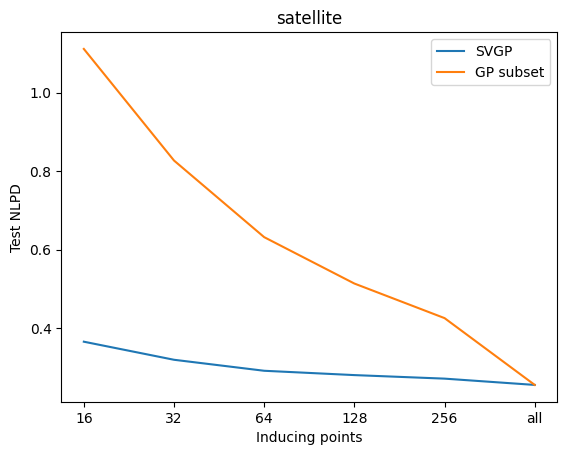

In [349]:
for dataset in nll_dict:
    plt.clf()
    fig, ax = plt.subplots()
    res_array = nll_dict[dataset]
    svgp_res = res_array[:, 0]
    subset_res = res_array[:, 1]
    plt.plot(svgp_res, label='SVGP')
    
    plt.plot(subset_res, label='GP subset')
    ax.set_xticklabels([0] +inducing_points)
    plt.title(dataset)
    plt.xlabel('Inducing points')
    plt.ylabel('Test NLPD')
    plt.legend()
    plt.savefig(f'plots/{dataset}.png', bbox_inches='tight')

<h2>Create img result table </h2>

In [213]:
def get_val_best_img(result_list, deltas, model_name='svgp_ntk'):
    print(model_name)
    valid_nlls = np.zeros((len(result_list), len(deltas)))
    for i, results in enumerate(result_list):
        for j, delta in enumerate(deltas):
            valid_res = results[delta]['nll_va']
            valid_nlls[i, j] = valid_res
    mean_nlls = np.mean(valid_nlls, axis=0)
    print(mean_nlls)
    min_nll = mean_nlls.min()
    min_index = list(mean_nlls).index(min_nll)
    return min_index

def get_result_list_img(dataset, seeds, name='sparse_1000', model='MLP'):   
    result_list = []
    deltas = []
    dir_name = f'../experiments/results/{dataset}/models/'
    for seed in seeds:
        seed_res = dict()
        for file in os.listdir(dir_name):
            ds, m, s, delta = file[:-3].split('_')
            if m != model:
                continue
            if s != seed:
                continue
            state = torch.load(file)
            if f'svgp_ntk_{name}' not in state:
                continue
            seed_res[delta] = state[f'svgp_ntk_{name}']
            deltas.append(delta)
        if len(seed_res) > 0:
            result_list.append(seed_res)
    deltas = list(set(deltas))
    print(f'N seeds: {len(result_list)}')
    return result_list, deltas
                          
def get_test_mean_std_img(result_list, deltas, min_idx):
    test_nlls = np.zeros(len(result_list))
    min_delta = deltas[min_idx]
    for i, results in enumerate(result_list):
        test_nlls[i] = results[min_delta]['nll_te']
    mean = np.mean(test_nlls)
    std = np.std(test_nlls)
    return (mean, std)

In [266]:
method_map_img = {
    'MAP': {'nll': [(0.258, 0.004), (0.605, 0.007)] , 'ece': [(0.017, 0.001), (0.066, 0.004)], 'acc':[(91.39, 0.11), (80.92, 0.32)], 'ood-auc': [(0.864, 0.014), (0.792, 0.008)]} ,
'BNN predictive': {'nll': [(0.942, 0.016), (2.114, 0.021)] , 'ece': [(0.411, 0.008), (0.095, 0.012)], 'acc':[(84.42, 0.12), (21.74, 0.80)], 'ood-auc': [(0.945, 0.002), (0.689, 0.020)]} ,
'BNN predictive (Ritter et al.)' : {'nll': [(0.265, 0.004), (0.588, 0.005)] , 'ece': [(0.024, 0.002), (0.052, 0.005)], 'acc':[(91.20, 0.07), (80.78, 0.36)], 'ood-auc': [(0.947, 0.006), (0.783, 0.007)]}  ,
'GLM predictive' :{'nll': [(0.244, 0.003), (0.601, 0.008)] , 'ece': [(0.012, 0.003), (0.084, 0.010)], 'acc':[(92.25, 0.10), (81.37, 0.15)], 'ood-auc': [(0.955, 0.006), (0.843, 0.016)]}  ,
'GP predictive' : {'nll': [(0.250, 0.004), (0.555, 0.008)] , 'ece': [(0.007, 0.001), (0.017, 0.003)], 'acc':[(91.36, 0.11), (81.01, 0.32)], 'ood-auc': [(0.918, 0.010), (0.820, 0.013)]} ,
'SVGP predictive' : {'nll': [(0, 0), (0.0, 0.00)] , 'ece': [(0.00, 0.000), (0.00, 0.000)], 'acc':[(0.00, 0.00), (0.00, 0.00)], 'ood-auc': [(0.00, 0.00), (0.00, 0.00)]}
}

In [267]:
exper_names = ['sparse_1000']
pretty_names = {'sparse_1000_svgp_ntk': 'SVGP (1000)'}
method_names = ['svgp_ntk']
datasets = ['FMNIST', 'CIFAR10']
model = 'MLP'
data_names = ['FMNIST', 'CIFAR10']
metrics = ['acc', 'nll', 'ece', 'ood-auc']
seeds = [117, 68, 187, 27, 51]
assert 1 == 0
for exp_name in exper_names:
    for method_name in method_names:
        table_list = []
        print(method_name)
        for dataset in datasets:
            print(dataset)
            result_list, deltas = get_result_list_img(dataset,  seeds, name=exper_name,  model=model)
            print('N seeds:')
            print(len(result_list))
            if len(result_list) == 0:
                table_list.append((0, 0))
                continue
            min_idx = get_val_best_img(result_list, deltas)
            (mean, std) = get_test_mean_std_img(result_list, min_idx, name=method_name)
            table_list.append((round(mean, 3), round(std, 3)))
        method_map_img[pretty_names[exp_name+'_'+method_name]] = table_list

AssertionError: 

In [270]:
import os


lines = []
lines.append(r'\begin{tabular}{l C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw}  C{0.6\tblw}}')
lines.append(r'\toprule')
header_str = ''
for metric in metrics:
    header_str += f'& {metric} '
header_str += r' \\'
lines.append(header_str)
lines.append(r'\midrule')
for i, dataset in enumerate(datasets):
    for method_name in method_map_img:
        line_str = f'\sc {dataset} and {method_name} &'
        for metric in metrics:
            (mean, var) = method_map_img[method_name][metric][i]
            mean_var = f'{mean} {var}'
            line_str += r' \val{'
            line_str += str(mean)
            line_str += '}{'
            line_str += str(var)
            line_str += '} &'
        line_str = line_str[:-2]
        line_str += r' \\'
        lines.append(line_str)
lines.append(r'\bottomrule')
lines.append(r'\end{tabular}')
tex_file = 'img_super.tex'

os.remove(tex_file)
with open(tex_file, 'a') as file:
    for line in lines:
        file.write(line+'\n')
    
print(lines)

['\\begin{tabular}{l C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw}  C{0.6\\tblw}}', '\\toprule', '& acc & nll & ece & ood-auc  \\\\', '\\midrule', '\\sc FMNIST and MAP & \\val{91.39}{0.11} & \\val{0.258}{0.004} & \\val{0.017}{0.001} & \\val{0.864}{0.014} \\\\', '\\sc FMNIST and BNN predictive & \\val{84.42}{0.12} & \\val{0.942}{0.016} & \\val{0.411}{0.008} & \\val{0.945}{0.002} \\\\', '\\sc FMNIST and BNN predictive (Ritter et al.) & \\val{91.2}{0.07} & \\val{0.265}{0.004} & \\val{0.024}{0.002} & \\val{0.947}{0.006} \\\\', '\\sc FMNIST and GLM predictive & \\val{92.25}{0.1} & \\val{0.244}{0.003} & \\val{0.012}{0.003} & \\val{0.955}{0.006} \\\\', '\\sc FMNIST and GP predictive & \\val{91.36}{0.11} & \\val{0.25}{0.004} & \\val{0.007}{0.001} & \\val{0.918}{0.01} \\\\', '\\sc FMNIST and SVGP predictive & \\val{0.0}{0.0} & \\val{0}{0} & \\val{0.0}{0.0} & \\val{0.0}{0.0} \\\\', '\\sc CIFAR10 and MAP & \\val{80.92}{0.32} & \\val{0.605}{0.007} & \\val{0.066}{0.004} & \\val{0

<h2>Run Image experiments </h2>

In [92]:
ds = 'MNIST'
model = 'MLP'
seed = 117

In [96]:
!python3 ../experiments/imgclassification.py -d {ds} -m {model} -s {seed}

Writing results to ../experiments/results/MNIST
Reading data from ../data
Dataset: MNIST
Seed: 117
9920512it [00:00, 12327924.77it/s]                                              
Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw
32768it [00:00, 298645.29it/s]
Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw
1654784it [00:00, 6915425.85it/s]                                               
Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw
8192it [00:00, 29604.16it/s]                                                    
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
/Users/tamire1/miniconda3/envs/bnn-env-3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor